### Data Preprocessing

In [1]:
import preprocessor
import demoji
import pandas as pd

# Load and preprocess your dataset
def preprocess_text(text):
    # Use tweet-preprocessor to clean tweets
    cleaned_text = preprocessor.clean(text)
    # Remove emojis
    cleaned_text = remove_emojis(cleaned_text)
    return cleaned_text

def remove_emojis(text):
    return demoji.replace(text, '')

# Load your dataset with columns 'tweet' and 'categories'
df = pd.read_csv("/Users/Hsuweic/Desktop/AI4healthcare/dataset/dataset_categories.csv")
hate_speech = df[df['label'] == 1].copy() 
# Reset the index to ensure it is consecutive
hate_speech.reset_index(drop=True, inplace=True)

# Preprocess text
hate_speech['cleaned_tweet'] = hate_speech['tweet'].apply(preprocess_text)

print(hate_speech.shape)
print(hate_speech.columns)
print(len(hate_speech))

(1430, 5)
Index(['Unnamed: 0', 'tweet', 'label', 'categories', 'cleaned_tweet'], dtype='object')
1430


In [2]:
# Convert categories to numerical labels
label_dict = {category: idx for idx, category in enumerate(hate_speech['categories'].unique())}
hate_speech['label'] = hate_speech['categories'].map(label_dict)

# Print label_dict to see the mapping
print("Label Dictionary:")
print(label_dict)
print(hate_speech.head(10))

Label Dictionary:
{'Race': 0, 'Sexual Orientation': 1, 'Gender': 2, 'Religion': 3, 'Disability': 4, 'Physical Appearance': 5, 'Class': 6, 'Ethnicity': 7, 'Behavior': 8}
   Unnamed: 0                                              tweet  label   
0           1  Scandal: A Negro Bed Wench's Fairy-tale and pr...      0  \
1           3  Why does this faggot in front of me have to ge...      1   
2           4  RT @ERlKTweets: what the fuck is this disgusti...      0   
3           6  @PaulMoon8 @yurista4life @justinmiculka01 you ...      2   
4          15  Black cops want to kill white citizens. Spic c...      0   
5          16  RT "@TIMAtheRACER: Wow do we have another fagg...      1   
6          17  @kitlange stop oppressing me! Have you heard o...      3   
7          18  I hate when white trash try to act like they'r...      0   
8          19  @klejdys He may be 'hustlin' but he studied Cr...      0   
9          21  &#8220;@FreddieGibbs: Tea bag a bitch.&#8221; ...      2   

     

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    hate_speech['cleaned_tweet'],  # Features
    hate_speech['label'],  # Labels
    test_size=0.2,  # Adjust as needed
    random_state=42
)

# Reset the index to ensure it is consecutive
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

print(X_train.head(10))
print(type(X_train))
print(len(X_train))
print(X_train.shape)
print(X_train.name)
# print(y_train.head(10))
# print(len(y_train))
# print(X_test.head(10))
# print(len(X_test))
# print(y_test.head(10))
# print(len(y_test))

0    : A real nigga gone teach his bitch the game n...
1    Sick of your coon antics RT : Accuracy RT : &;...
2                              This niggah know wassup
3    : if u dont want your heart broken then dont c...
4    sweet comeback u fuckin herb I dnt watch socce...
5    : Do you ever just see someone's account and t...
6    they are wrong you are a nigger always causung...
7    fucking block your white ass because you try t...
8    : if i dont get drafted for the squad we gonna...
9    "We're out here, and we're queer!"" , , , hut!...
Name: cleaned_tweet, dtype: object
<class 'pandas.core.series.Series'>
1144
(1144,)
cleaned_tweet


### Logistic Regression + Softmax

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Logistic Regression with multinomial (softmax)
logreg_multinomial = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
logreg_multinomial.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred_multinomial = logreg_multinomial.predict(X_test_tfidf)

# Evaluate the model with multinomial (softmax)
print("\nLogistic Regression with Multinomial (Softmax):")
print(classification_report(y_test, y_pred_multinomial, target_names=label_dict.keys()))


Logistic Regression with Multinomial (Softmax):
                     precision    recall  f1-score   support

               Race       0.67      0.92      0.77       109
 Sexual Orientation       0.91      0.90      0.90        78
             Gender       0.57      0.64      0.60        50
           Religion       0.00      0.00      0.00        13
         Disability       0.67      0.25      0.36         8
Physical Appearance       0.00      0.00      0.00        16
              Class       0.00      0.00      0.00         3
          Ethnicity       0.00      0.00      0.00         6
           Behavior       0.00      0.00      0.00         3

           accuracy                           0.71       286
          macro avg       0.31      0.30      0.29       286
       weighted avg       0.62      0.71      0.66       286



/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### BERTweet model

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load BERTweet model and tokenizer
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

hate_categories = 9  # Number of categories
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=hate_categories)


/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Tokenize and prepare input data
max_length = 128  # You can adjust this based on your requirements

def tokenize_data(text):
    return tokenizer(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

# Tokenize input data
tokenized_data = hate_speech['cleaned_tweet'].apply(tokenize_data)

# # Convert categories to numerical labels
# label_dict = {category: idx for idx, category in enumerate(hate_speech['categories'].unique())}
# hate_speech['label'] = hate_speech['categories'].map(label_dict)

# # Print label_dict to see the mapping
# print("Label Dictionary:")
# print(label_dict)
# # print(hate_speech['label'].unique())
print(len(tokenized_data))
print(tokenized_data)

# Prepare input tensors
input_ids = torch.cat([tokenized_data[i]['input_ids'] for i in range(len(tokenized_data))], dim=0)
attention_masks = torch.cat([tokenized_data[i]['attention_mask'] for i in range(len(tokenized_data))], dim=0)
labels = torch.tensor(hate_speech['label'].values)

# Create DataLoader
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


<class 'pandas.core.series.Series'>
1430
0       [input_ids, token_type_ids, attention_mask]
1       [input_ids, token_type_ids, attention_mask]
2       [input_ids, token_type_ids, attention_mask]
3       [input_ids, token_type_ids, attention_mask]
4       [input_ids, token_type_ids, attention_mask]
                           ...                     
1425    [input_ids, token_type_ids, attention_mask]
1426    [input_ids, token_type_ids, attention_mask]
1427    [input_ids, token_type_ids, attention_mask]
1428    [input_ids, token_type_ids, attention_mask]
1429    [input_ids, token_type_ids, attention_mask]
Name: cleaned_tweet, Length: 1430, dtype: object


In [7]:
def tokenize_data(text):
    return tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

# Tokenize and prepare input data for training set
tokenized_train = X_train.apply(tokenize_data)
print(len(tokenized_train))
print(tokenized_train)

input_ids_train = torch.cat([tokenized_train[i]['input_ids'] for i in range(len(tokenized_train))], dim=0)
attention_masks_train = torch.cat([tokenized_train[i]['attention_mask'] for i in range(len(tokenized_train))], dim=0)
labels_train = torch.tensor(y_train.values)

# Create DataLoader for training set
from torch.utils.data import DataLoader, TensorDataset
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)

1144
0       [input_ids, token_type_ids, attention_mask]
1       [input_ids, token_type_ids, attention_mask]
2       [input_ids, token_type_ids, attention_mask]
3       [input_ids, token_type_ids, attention_mask]
4       [input_ids, token_type_ids, attention_mask]
                           ...                     
1139    [input_ids, token_type_ids, attention_mask]
1140    [input_ids, token_type_ids, attention_mask]
1141    [input_ids, token_type_ids, attention_mask]
1142    [input_ids, token_type_ids, attention_mask]
1143    [input_ids, token_type_ids, attention_mask]
Name: cleaned_tweet, Length: 1144, dtype: object


Start Training
=== Start Batch 0 ===
1.8367869853973389
=== Start Batch 1 ===
3.1182576417922974
=== Start Batch 2 ===
4.283602952957153
=== Start Batch 3 ===
5.771800637245178
=== Start Batch 4 ===
7.332326054573059
=== Start Batch 5 ===
8.454647541046143
=== Start Batch 6 ===
9.653226494789124
=== Start Batch 7 ===
11.152984857559204
=== Start Batch 8 ===
12.311897277832031
=== Start Batch 9 ===
14.313760042190552
=== Start Batch 10 ===
15.786075830459595
=== Start Batch 11 ===
17.31002676486969
=== Start Batch 12 ===
18.63794243335724
=== Start Batch 13 ===
20.45743465423584
=== Start Batch 14 ===
22.0542995929718
=== Start Batch 15 ===
23.970901489257812
=== Start Batch 16 ===
26.334065198898315
=== Start Batch 17 ===
28.214422583580017
=== Start Batch 18 ===
29.795998454093933
=== Start Batch 19 ===
31.078032851219177
=== Start Batch 20 ===
32.644795060157776
=== Start Batch 21 ===
33.91679561138153
=== Start Batch 22 ===
35.66980850696564
=== Start Batch 23 ===
37.145241498947144

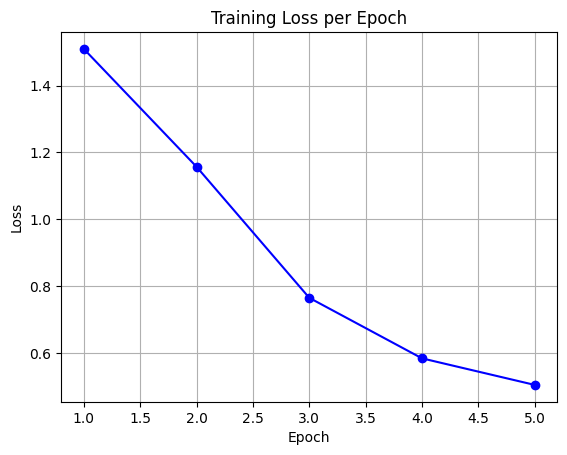

In [11]:
from transformers import AdamW
from torch.nn import CrossEntropyLoss

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

# Set up training parameters
num_epochs = 5  # You can adjust this based on your requirements
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model and data to the device
model.to(device)
input_ids_train, attention_masks_train, labels_train = input_ids_train.to(device), attention_masks_train.to(device), labels_train.to(device)
loss_per_epoch = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    print("Start Training")
    total_loss = 0
    n = 0
    for batch in dataloader_train:
        print("=== Start Batch " + str(n) + " ===")
        batch_input_ids, batch_attention_masks, batch_labels = batch
        batch_input_ids, batch_attention_masks, batch_labels = (
            batch_input_ids.to(device),
            batch_attention_masks.to(device),
            batch_labels.to(device),
        )

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_masks,
            labels=batch_labels,
        )

        # Calculate loss
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        total_loss += loss.item()
        print(total_loss)

        n = n+1

    # Print average loss for the epoch
    average_loss = total_loss / len(dataloader_train)
    loss_per_epoch.append(average_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")

# Save the trained model (This method is specific to the transformers library and is designed for saving transformer-based models.
# It saves the model in a format that includes the architecture, parameters, and additional information specific to the transformers library.
# It provides a higher-level abstraction that is specific to transformer models and allows for easily loading the model using AutoModel.from_pretrained later.)
model.save_pretrained("/Users/Hsuweic/Desktop/AI4health/model/BERTweet model")
tokenizer.save_pretrained("/Users/Hsuweic/Desktop/AI4health/model/BERTweet model")

import matplotlib.pyplot as plt
# Plot the loss values
plt.plot(range(1, len(loss_per_epoch) + 1), loss_per_epoch, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# trained model
# batch size = 8
# epoch = 5
# total training time = 190 mins
# optimizer = AdamW

In [13]:
# Tokenize and prepare input data for testing set
tokenized_test = X_test.apply(tokenize_data)
# print(len(tokenized_test))
# print(tokenized_test)

input_ids_test = torch.cat([tokenized_test[i]['input_ids'] for i in range(len(tokenized_test))], dim=0)
attention_masks_test = torch.cat([tokenized_test[i]['attention_mask'] for i in range(len(tokenized_test))], dim=0)
labels_test = torch.tensor(y_test.values)

# Create DataLoader for testing set
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=False)

# Evaluation loop
model.eval()
all_preds = []

with torch.no_grad():
    for batch in dataloader_test:
        input_ids, attention_masks, labels = [tensor.to(device) for tensor in batch]

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       109
           1       0.91      0.95      0.93        78
           2       0.68      0.76      0.72        50
           3       0.89      0.62      0.73        13
           4       0.50      0.38      0.43         8
           5       0.89      0.50      0.64        16
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         3

    accuracy                           0.80       286
   macro avg       0.52      0.46      0.48       286
weighted avg       0.77      0.80      0.78       286



/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model Inference
Label Dictionary:
{'Race': 0, 'Sexual Orientation': 1, 'Gender': 2, 'Religion': 3, 'Disability': 4, 'Physical Appearance': 5, 'Class': 6, 'Ethnicity': 7, 'Behavior': 8}

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Example input tweet
input_tweet = "you are a nasty bitch and I hate you"

# Load the BERTweet tokenizer and model
model_path = "/Users/Hsuweic/Desktop/AI4health/model/BERTweet classification model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=9)  # Assuming 9 classes

# Tokenize the input tweet
inputs = tokenizer(input_tweet, return_tensors="pt")

# Forward pass through the model to obtain logits
with torch.no_grad():
    outputs = model(**inputs)

# Get logits from the output
logits = outputs.logits

# Apply softmax to get probabilities
probabilities = torch.nn.functional.softmax(logits, dim=1)

# Choose the predicted class
predicted_class = torch.argmax(probabilities, dim=1).item()

print("Predicted class:", predicted_class)



Predicted class: 2
